# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
# Import necessary libraries
import sys
sys.path.append("") 

import os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import regex as re
import string
import json
# import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from collections import defaultdict
# from textwrap import wrap

# Torch ML libraries
# import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

#metrics
# from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Misc.
import warnings
warnings.filterwarnings('ignore')

2024-11-23 12:10:08.272091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 12:10:08.362445: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 12:10:08.793707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-23 12:10:08.793791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("Using CPU")

CUDA is available.


In [19]:
CURRENT_PATH = os.getcwd()
TRAINING_DATASET_PATH = f"{CURRENT_PATH}/dataset"
OUTPUT_DIR = f"{CURRENT_PATH}/output"
RAW_DATASET_PATH = "vlsp_sentiment_train.csv"
stop_words_path = "vietnamese-stopwords.txt"
MAX_LEN = 90
RANDOM_SEED =42
class_names = ['POS', 'NEG', 'NEU']

### Load the data

In [4]:
dataset = pd.read_csv(RAW_DATASET_PATH,  on_bad_lines='skip', delimiter="\t")

In [5]:
dataset.shape

(5100, 2)

We can see that the most relevant column for us is content and replyContent and the score as well.

In [6]:
dataset.columns

Index(['Class', 'Data'], dtype='object')

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* -1 - negative
* 0 - neutral 
* 1 - positive

In [7]:
dataset.describe()

,Class
count,5100.000000
mean,0.000000
std,0.816577
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
dataset=dataset.drop_duplicates("Data")
dataset = dataset.dropna()

In [9]:
dataset["Class"].value_counts()

Class
 0    1697
-1    1693
 1    1672
Name: count, dtype: int64

In [10]:
dataset["Data"].sample(40)

4664    Dàn này chắc thiết kế ra để dùng vs curved TV ...
3128    đẹp ,cấu hình ngon, mà mình sài Htc rồi máy bề...
2500               Đang xài Surface pro 3. Quá tuyệt vời.
3358    sony xperia z1 bạn nhé, cấu hình mạnh cam...
1253                                 Tần số quet thấp quá
1325    Android thì chỉ chơi Sony hay HTC. Samsung chỉ...
1163    Apple lên bỏ nút home đi. giờ nó không có tác ...
1616    Đúng thế con neo 7 màn hình qhd mà giá gần 4tr...
354     Nói gì thì nói mình lương tháng 21tr cũng khôn...
859                     Cho tiền ko xài. Ngán Androi zoài
3535    đa phần các dịch vụ bạn dùng đều k hỗ trợ Việt...
1760                                             ngon quá
3135    Máy đẹp đó, chất lượng hoàn thiện cực tốt, cấu...
1902    Trước tôi đc cô cho 1 em samsung nắp gập rất b...
475     Hi, vậy Iphone 6S màu vàng hồng bị bong tróc v...
1016    Mình hôm nay lại phát hiện thêm lỗi nữa,...
4770    Con này ra mà giốn hệt 5s thì sẽ rất ít người ...
3339      Giá 

In [11]:
import regex as re
import string
import json

emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    text = text.lower()
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    # text = re.sub(r"(\d)([^\d.])", r"\1 \2", text)
    # text = re.sub(r"([^\d.])(\d)", r"\1 \2", text)
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text)
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
    text = re.sub(r"\s+", " ", text)
    return text

from pyvi import ViTokenizer

def tokenizingText(text):
    return ViTokenizer.tokenize(text)

lookup_dict = { 'sf': 'sản phẩm','cx':'cũng','kg':'kilogam', 'k':'không', 'ko':'không', 'hong':'không', 'kh':'không', 'kt':'kiểm tra', 'ktra':'kiểm tra', 'bt':'biết', 'pít': 'biết', 'píc': 'biết','v': 'với', 'sl': 'số lượng' ,'dk' : 'được', 'dc' : 'được', 'đc' : 'được' ,'chat' : 'chất' ,'okela' : 'tốt' , 'mn' : 'mọi người', 'sp' : 'sản phẩm', 'ib' : 'inbox', 'nt': 'nhắn tin', 'qc': 'quảng cáo', 'sd': 'sử dụng', 'g': 'giờ', 'dv': 'dịch vụ', 'vs': 'với', 'wa': 'qua', 'tgian' :' thời gian', 'tg' :' thời gian', 'tl' : 'trả lời', 'dx' : 'được', 'ntn' : 'như thế này', 'trc' :'trước'}

def text_std(input_text):
    words = input_text.split()
    new_words = []
    for word in words:
        word = re.sub(r'[^\w\s]','', word)
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word)
    new_text = " ".join(new_words)
    return new_text

normalized_string = lambda x: " ".join(x.lower() for x in x.split())

with open(stop_words_path, 'r', encoding='utf-8') as file:
    stop_words = file.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def map_label(label):
    label_map = {
        "POS": 0,
        "NEG": 1,
        "NEU": 2
    }
    return label_map[label]

In [12]:
dataset["Data"] = dataset["Data"].map(lambda text: clean_text(text))
dataset["Data"] = dataset["Data"].apply(text_std)
# dataset["content"] = dataset["content"].apply(remove_stopwords)
dataset["Data"] = dataset["Data"].apply(normalized_string)
dataset["Data"] = dataset["Data"].apply(tokenizingText)
# dataset["label"] = dataset["label"].map(lambda label: map_label(label))

In [13]:
dataset.head(10)

,Class,Data
0,-1,mình đã dùng anywhere thế_hệ đầu quả là đầy th...
1,-1,quan_tâm nhất là độ trễ có cao không dùng thi_...
2,-1,dag xài con cùi bắp 98k pin trâu mỗi tội đánh ...
3,-1,logitech chắc hàng phải tiền triệu trở lên dùn...
4,-1,đang xài con m175 cùi mía nhà xài nhiều chuột ...
5,-1,đang xài 2 con m185 nút chuột giữa hai con đều...
6,-1,con anywhere 1 mình dùng bị double click cũng ...
7,-1,hàng cty cấp cấp xong vứt ở nhà xài con xornet...
8,-1,magic mouse mà ngon hơn mới_lạ magic mouse chỉ...
9,-1,em giống y bác luôn chán bluetoth kinh_hồn 1tr...


## Data Preprocessing

In [14]:
# Set the model name
MODEL_NAME = 'trituenhantaoio/bert-base-vietnamese-uncased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/207k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

In [15]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [17]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in dataset.Data:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


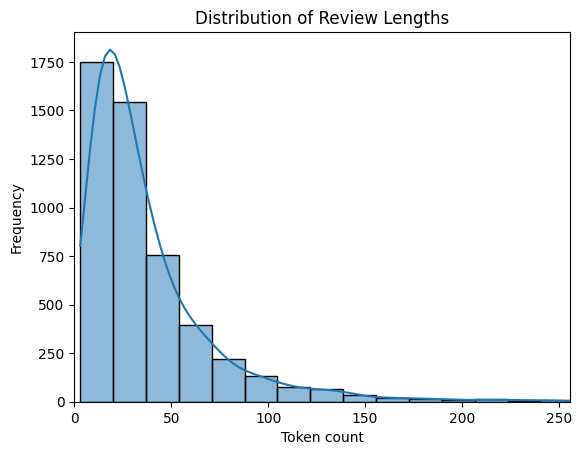

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of review lengths using histplot
sns.histplot(token_lens, kde=True, bins=30)  # `kde=True` adds the kernel density estimate
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


In [25]:
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED,stratify=dataset['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test['label'])
print(df_train.shape, df_val.shape, df_test.shape)

(14645, 2) (1831, 2) (1831, 2)


In [26]:
from sklearn.utils import shuffle
df_train = pd.concat([df_train, df_val.sample(frac=0.62, random_state=RANDOM_SEED)])
df_train = pd.concat([df_train, df_test.sample(frac=0.5, random_state=RANDOM_SEED)])

df_train = shuffle(df_train, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(16696, 2) (1831, 2) (1831, 2)


In [27]:
df_train=df_train.drop_duplicates("content")
print(df_train.shape, df_val.shape, df_test.shape)

(16696, 2) (1831, 2) (1831, 2)


In [28]:
df_train.to_csv("/kaggle/working/train.csv", index=False)
df_val.to_csv("/kaggle/working/val.csv", index=False)
df_test.to_csv("/kaggle/working/test.csv", index=False)

# Create Pytorch Dataset

In [29]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [31]:
# Create train, test and val data loaders
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 90])
torch.Size([32, 90])
torch.Size([32])


## Sentiment Classification with BERT

**Load the dataset**

In [33]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [34]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    
    def forward(self, input_ids, attention_mask):
            bert_output = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            pooled_output = bert_output.pooler_output # Accessing the pooled output
            #  Add a dropout layer
            output = self.drop(pooled_output)
            return self.out(output)

In [35]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [36]:
# Number of iterations 
EPOCHS = 15

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for i,d in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
%%time

history = defaultdict(list)
best_accuracy = 0
best_loss = 100
patient = 2
patient_count = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val loss {val_loss} accuracy {val_acc}")
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy and best_loss > val_loss:
        model_name = f"model_state_{epoch}.bin"
        torch.save(model.state_dict(), model_name)
        best_accuracy = val_acc
        best_loss = val_loss
    elif(best_loss < val_loss):
        patient_count = patient_count +1
        if (patient_count >= patient):
            print("Early Stop trigger")
            break;

Epoch 1/15
----------
Train loss 0.7568608765058591 accuracy 0.6636919022520364
Val loss 0.6289482820650627 accuracy 0.7274713271436373
Epoch 2/15
----------
Train loss 0.6115848445743893 accuracy 0.736942980354576
Val loss 0.5723883093431078 accuracy 0.7602403058438011
Epoch 3/15
----------
Train loss 0.5209068694505198 accuracy 0.7822831816003833
Val loss 0.5378348919852026 accuracy 0.7831785909339158
Epoch 4/15
----------
Train loss 0.432245410564873 accuracy 0.8277431720172497
Val loss 0.5065873278112247 accuracy 0.813216821409066
Epoch 5/15
----------
Train loss 0.3565679642575226 accuracy 0.8633804504072832
Val loss 0.5014482785401673 accuracy 0.8159475696340797
Epoch 6/15
----------
Train loss 0.29193590183910056 accuracy 0.891111643507427
Val loss 0.5131648663302948 accuracy 0.8241398143091206
Epoch 7/15
----------
Train loss 0.2374444307894999 accuracy 0.9136919022520364
Val loss 0.5276342196197346 accuracy 0.8367012561441834
Early Stop trigger
CPU times: user 14min 33s, sys: 

In [104]:
# history = {
#     'train_acc': [0.7754, 0.8974, 0.9333, 0.9561],
#     'val_acc': [0.8578, 0.8981, 0.9191, 0.9252],
#     'train_loss': [0.5609, 0.2872, 0.1936, 0.1281],
#     'val_loss': [0.3937, 0.2986, 0.2445, 0.2399]
# }


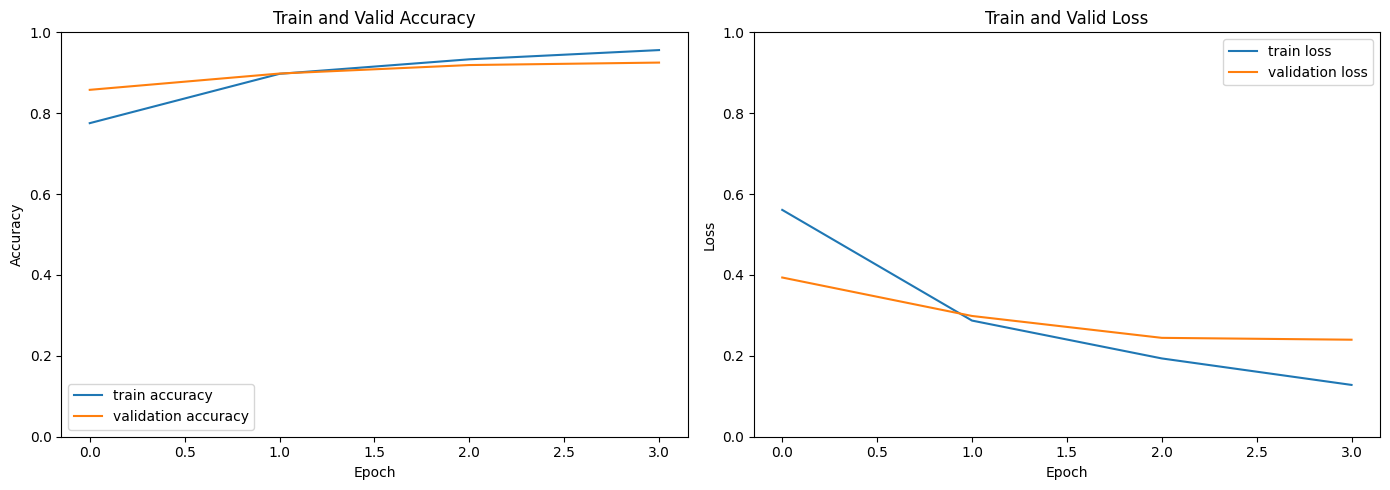

In [109]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss on the first subplot (left)
ax2.plot(history['train_loss'], label='train loss')
ax2.plot(history['val_loss'], label='validation loss')
ax2.set_title('Train and Valid Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim([0, 1])

# Plot training and validation accuracy on the second subplot (right)
ax1.plot(history['train_acc'], label='train accuracy')
ax1.plot(history['val_acc'], label='validation accuracy')
ax1.set_title('Train and Valid Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.set_ylim([0, 1])

# Display the plots
plt.tight_layout()
plt.show()


# Test model

In [42]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8143091206990715

In [43]:

# Đường dẫn để lưu tokenizer
output_dir = "/kaggle/working/"

# Lưu tokenizer
tokenizer.save_pretrained(output_dir)

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.txt',
 '/kaggle/working/added_tokens.json')

In [44]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME,config =config)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    
    def forward(self, input_ids, attention_mask):
            bert_output = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            pooled_output = bert_output.pooler_output # Accessing the pooled output
            #  Add a dropout layer
            output = self.drop(pooled_output)
            return self.out(output)

In [82]:
import os
from transformers import BertTokenizer, BertConfig, BertModel
MODEL_NAME = "trituenhantaoio/bert-base-vietnamese-uncased"
model_path = "/kaggle/input/sentiment/bert-base-uncased"
# Tải cấu hình của mô hình từ tệp config.json
config = BertConfig.from_pretrained(MODEL_NAME)

# Tải tokenizer từ thư mục chứa các tệp nhị phân đã lưu trữ
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Tải mô hình từ thư mục chứa các tệp nhị phân đã lưu trữ
model_bert_sentiment = SentimentClassifier(3)
model_bert_sentiment.load_state_dict(torch.load('/kaggle/input/sentiment/pytorch_model.bin'))

# Đảm bảo mô hình ở chế độ evaluation
model_bert_sentiment.eval()
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_bert_sentiment.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [83]:
test_acc, _ = eval_model(
  model_bert_sentiment,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9142545057345712

In [84]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [85]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model_bert_sentiment,
    test_data_loader
)

In [86]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         POS       0.96      0.91      0.93       687
         NEG       0.93      0.96      0.94       689
         NEU       0.84      0.86      0.85       455

    accuracy                           0.91      1831
   macro avg       0.91      0.91      0.91      1831
weighted avg       0.92      0.91      0.91      1831



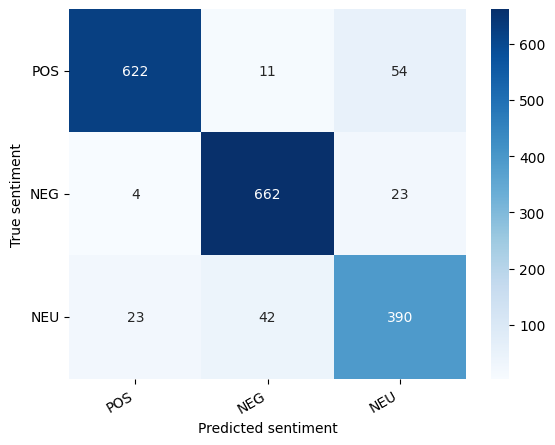

In [87]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [51]:
review_text = "Sản phẩm này cũng tạm được"

In [52]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)

In [53]:
import torch.nn.functional as F

input_ids = encoded_review['input_ids'].to('cuda')
attention_mask = encoded_review['attention_mask'].to('cuda')

output = model_bert_sentiment(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


probs = F.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    print(f'{class_name} probability: {probs[0][i].item():.4f}')

# In ra review text và nhãn dự đoán
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


POS probability: 0.0302
NEG probability: 0.0181
NEU probability: 0.9517
Review text: Sản phẩm này cũng tạm được
Sentiment  : NEU


# **RCNN**

In [54]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)

2024-06-11 08:22:05.229383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 08:22:05.229511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 08:22:05.357021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


3.3.3
2.15.0


In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re
import string
from tqdm import tqdm
import numpy as np
import os 
import gensim
from gensim.models import KeyedVectors
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, LSTM, Conv1D, MaxPooling1D, Input, Reshape, GRU, Bidirectional, Convolution1D
from keras import Model, models, optimizers

In [56]:
# df_train = pd.read_csv('/kaggle/input/sentiment/train.csv')
# df_val = pd.read_csv("/kaggle/input/sentiment/val.csv")
# df_test = pd.read_csv("/kaggle/input/sentiment/test.csv")
df_train = pd.read_csv('/kaggle/working/train.csv')
df_val = pd.read_csv("/kaggle/working/val.csv")
df_test = pd.read_csv("/kaggle/working/test.csv")

In [57]:
!pip install pyvi

In [58]:
from pyvi import ViTokenizer
def TokenizingText(text):
    return ViTokenizer.tokenize(text)

In [59]:
df_train['content']= df_train['content'].apply(TokenizingText)
df_val['content']= df_val['content'].apply(TokenizingText)
df_test['content']= df_test['content'].apply(TokenizingText)

In [60]:
X_train = df_train['content']
X_val = df_val['content']
X_test = df_test['content']

Y_train = df_train['label']
Y_val = df_val['label']
Y_test = df_test['label']

In [61]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) 
X_train_tfidf =  tfidf_vect.transform(X_train)
X_val_tfidf =  tfidf_vect.transform(X_val)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [62]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)
X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [63]:
tf.keras.backend.clear_session()

In [ ]:
from keras.callbacks import EarlyStopping

RCNN_model = Sequential()

RCNN_model.add(Input(shape=(300,)))
RCNN_model.add(Reshape((10, 30)))
RCNN_model.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
RCNN_model.add(Convolution1D(100, 3, activation="relu"))
RCNN_model.add(Flatten())
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(512, activation='relu'))
RCNN_model.add(Dense(128, activation='relu'))
RCNN_model.add(Dense(3, activation='softmax'))
RCNN_model.summary()

RCNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)  

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_weights-{epoch:02d}.weights.h5'

# Define the checkpoint callback to save weights after every 5 epochs
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only the weights, not the entire model
    save_freq=1,  # Save after every 5 epochs (since data_generator yields 1 batch per step)
    verbose=1
)

history = RCNN_model.fit(X_train_tfidf_svd, Y_train, validation_data=(X_val_tfidf_svd, Y_val), epochs=5, batch_size=64, callbacks=[early_stop,checkpoint_callback]) 
    
val_predictions = RCNN_model.predict(X_val_tfidf_svd)
test_predictions = RCNN_model.predict(X_test_tfidf_svd)
val_predictions = val_predictions.argmax(axis=-1)
test_predictions = test_predictions.argmax(axis=-1)
    
print("Validation accuracy: ", metrics.accuracy_score(val_predictions, Y_val))
print("Test accuracy: ", metrics.accuracy_score(test_predictions, Y_test))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       122,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 100)         │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 938,599 (3.58 MB)

 Trainable params: 938,599 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5

Epoch 1: saving model to model_weights-01.weights.h5
  1/261 ━━━━━━━━━━━━━━━━━━━━ 32:06 7s/step - accuracy: 0.2812 - loss: 1.0985
Epoch 1: saving model to model_weights-01.weights.h5
  2/261 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.2969 - loss: 1.0974
Epoch 1: saving model to model_weights-01.weights.h5


I0000 00:00:1718094184.372652     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  3/261 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.3142 - loss: 1.0961
Epoch 1: saving model to model_weights-01.weights.h5
  4/261 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3216 - loss: 1.0956
Epoch 1: saving model to model_weights-01.weights.h5
  5/261 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.3292 - loss: 1.0953
Epoch 1: saving model to model_weights-01.weights.h5
  6/261 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.3359 - loss: 1.0940
Epoch 1: saving model to model_weights-01.weights.h5
  7/261 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.3402 - loss: 1.0931
Epoch 1: saving model to model_weights-01.weights.h5
  8/261 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.3431 - loss: 1.0925
Epoch 1: saving model to model_weights-01.weights.h5
  9/261 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.3470 - loss: 1.0915
Epoch 1: saving model to model_weights-01.weights.h5
 10/261 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.3500 - loss: 1.0908
Epoch 1: savi

In [ ]:
import matplotlib.pyplot as plt

# Lấy các giá trị từ lịch sử huấn luyện
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Vẽ đồ thị độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Tính toán classification report trên tập dữ liệu kiểm tra
class_report = classification_report(Y_test, test_predictions, target_names=['POS', 'NEG', 'NEU'])

# Hiển thị classification report
print("Classification Report:\n", class_report)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tính toán confusion matrix trên tập dữ liệu kiểm tra
conf_matrix = confusion_matrix(Y_test, test_predictions)

# Hiển thị confusion matrix bằng seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['POS', 'NEG', 'NEU'], yticklabels=['POS', 'NEG', 'NEU'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = RCNN_model.evaluate(X_test_tfidf_svd, Y_test)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


In [ ]:
for i in range(len(RCNN_model.weights)):
    RCNN_model.weights[i]._handle_name = RCNN_model.weights[i].name + "_" + str(i)

In [ ]:
from joblib import dump
RCNN_model.save("RCNN_model.h5")
dump(tfidf_vect, "/kaggle/working/tfidf_model.joblib")
dump(svd, "/kaggle/working/svd_model.joblib")


In [ ]:
import tensorflow as tf
import keras

rcnn_model = keras.models.load_model('/kaggle/working/model_weights-05.weights.h5')
svd = joblib.load('/kaggle/working/svd_model.joblib')
tfidf = joblib.load('/kaggle/working/tfidf_model.joblib')

In [ ]:
def rcnnSentiment(text):
    text_tfidf =  tfidf.transform(text)
    text_svd = svd.transform(text_tfidf)
    predictions = rcnn_model.predict(text_svd)
    print(predictions)

In [ ]:
rcnnSentiment("Sản phẩm này rất tốt, tôi rất thích nó")